# Unscented Kalman Filter(EKF) for GPS triangulation

This is a simple implementation of an Extended Kalman Filter for GPS triangulation. The filter is implemented in Python and tested with simulated data. The filter is able to estimate the position and velocity of a moving object given the GPS measurements with a certain accuracy.

## State Definition
The state of the system is defined as follows:
$$
\begin{align}
\mathbf{x} &= \begin{bmatrix} x \\ \dot{x} \\ y \\ \dot{y} \\ z \\ \dot{z} \\ cdt \\ c\dot{dt}\end{bmatrix}
\end{align}
$$
where $x,y,z$ are the position of the object in the ECEF frame, $v_x,v_y,v_z$ are the velocity of the object in the ECEF frame, $cdt$ is the reciever clock bias and $c\dot{dt}$ is the reciever clock drift in units of meters.

## State transition function:
Assuming constant velocity model, the state transition function $F$ can be calculated by using the unit time step model:
$$
A = \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix}
$$
Now the state transition function can be calculated as:
$$
F = \begin{bmatrix} A & 0 & 0 & 0 \\ 0 & A & 0 & 0 \\ 0 & 0 & A & 0 \\ 0 & 0 & 0 & A \end{bmatrix}
$$
which is and 8x8 matrix which maps the state at time $t$ to the state at time $t+1$.

## Process noise
The continuous time process noise matrix $Q$ is defined as:
$$
Q = \int_{0}^{\Delta t} F(t)Q_cF^T(t) dt
$$
where $Q_c$ is the continuous process noise matrix. This is the projection of the continuous noise onto the discrete time model. Defining $Q_c$ as:
$$
Q_c = \begin{bmatrix} 0 & 0 \\ 0 & 1  \end{bmatrix} \cdot \Phi_{B}^2
$$
where $\Phi_{B}$ is the spectral density of the process noise.

Now we can project the continuous time process noise onto the discrete time model:
$$
Q_p = \int_{0}^{\Delta t} F(t)Q_cF^T(t) dt = \begin{bmatrix} \frac{1}{3}\Delta t^3 & \frac{1}{2}\Delta t^2 \\ \frac{1}{2}\Delta t^2 & \Delta t \end{bmatrix} \cdot \Phi_{B}^2
$$
The clock covariance can be modelled by a random walk process defined by $S_p$ the white noise spectral density leading to random walk velocity error, and $S_g$ the white noise spectral density leading to random walk clock drift error. The process noise matrix $Q_c$ is then defined as:
$$
Q_c = \begin{bmatrix} S_f \Delta t +\frac{S_g\Delta t^3}{3}, S_g\frac{\Delta t^2}{2} \\ S_g\frac{\Delta t^2}{2} , S_g \Delta t  \end{bmatrix}
$$

So the final process noise matrix $Q$ is defined as:
$$
Q = \begin{bmatrix} Q_p, 0, 0, 0 \\ 0, Q_p, 0, 0 \\ 0, 0, Q_p, 0 \\ 0, 0, 0, Q_c \end{bmatrix}
$$

## Measurement covariance
The measurement covariance matrix is defined to be a diagonal matrix with uncorrected standard deviation $\sigma_r$ of the measurements. The measurement covariance matrix is defined as:
$$
R = \begin{bmatrix} \sigma_r^2, 0, 0 , 0 \\ 0, \sigma_r^2, 0 , 0\\ 0, 0, \sigma_r^2 ,0 \\  0, 0, 0, \sigma_r^2 \end{bmatrix}
$$
where $\sigma_r$ is the standard deviation of the pseudorange measurements. 

# The Measurement function
The measurement function $h$ to convert the state to the measurement space. To convert the state vector to the measurement space, we need to calculate the distance between the reciever and the GPS satellites plus the reciever clock offset error. Hence, the measurement function $h$ is defined as:
$$
h(x_s , s_i) = \sqrt {(x_s - x_i)^2 + (y_s - y_i)^2 + (z_s - z_i)^2} + cdt
$$
This is a non-linear function and hence a non-linear filter is required to estimate the state of the system.

In [1]:
import numpy as np
import numba as nb


def fx(x : np.ndarray, dt : float):
    """State transition function for the pseudorange GPS problem.

    Args:
        x (_type_): Current state vector.
        dt (_type_): Time step.
    """
    # Unit evolution matrix
    A = np.eye(2, dtype=np.float64)
    A[0,1] = dt

    # State transition function
    F = np.kron(np.eye(4, dtype=np.float64), A)

    return F @ x

def hx(x: np.ndarray , sv_location : np.ndarray) -> np.ndarray:
    """Measurement function for the pseudorange GPS problem.

    Args:
        x (_type_): Current state vector.
        sv_location (_type_): Location of the satellite.

    Returns:
        pseudorange: Pseudorange measurement for the given satellite.
    """
    # Grab the dt from the state vector
    dt = x[6]

    # Grab the position from the state vector
    position = np.array([x[0], x[2], x[4]], dtype=np.float64)

    # Compute the pseudorange
    return np.sqrt(np.power((sv_location - position) , 2).sum(axis=1))+ dt 

In [2]:
from filterpy.kalman import  UnscentedKalmanFilter
from filterpy.kalman import  MerweScaledSigmaPoints

# Dimensionality of the state vector
dim_x = 8
dim_z = 5
# Generate the sigma points
sigma_points = MerweScaledSigmaPoints(n=dim_x, alpha=.1, beta=2., kappa=-1)

# Create an Unscented Kalman Filter
ukf = UnscentedKalmanFilter(
    dim_x=dim_x,
    dim_z=dim_z,
    dt=30,
    hx=hx,
    fx=fx,
    points=sigma_points
)

In [3]:
# Initialize the mesurement noise and the process noise matrices 
from  filterpy.common import Q_discrete_white_noise

# Process noise
Q = np.kron(np.eye(dim_x // 2, dtype=np.float64), Q_discrete_white_noise(dim=2, dt=30, var=0.01))
S_f , S_g = 36., 0.01
Q_clock = np.array([[S_f * 30 , 0], [0, 0]]) + Q_discrete_white_noise(dim=2,dt=30,var=S_g)
Q[-2:,-2:] = Q_clock

# Measurement noise
R = np.eye(dim_z, dtype=np.float64) * 6**2 

In [4]:
# Initialize the filter 
ukf.x = np.ones(dim_x, dtype=np.float64) 
ukf.Q = Q  # Process noise 
ukf.R = R # Measurement noise
ukf.P = np.diag([10.] * dim_x) # Covariance matrix

In [5]:
import pandas as pd 

data = pd.read_csv("./data/filter.data")

In [6]:
from filterpy.common import Saver

saver = Saver(ukf)

In [7]:
for i in range(len(data)//5):
    # Get 5 measurements
    measurements = data.iloc[i*5:(i+1)*5,:]

    # Get range measurements and satellite locations
    ranges, sv_loc = measurements["range"].values, measurements[["x", "y", "z"]].values

    # Run the filter
    ukf.predict()
    ukf.update(ranges, sv_location=sv_loc)

    saver.save()    

In [8]:
import pandas as pd
preds = np.array(saver["x"])

data = pd.DataFrame(preds, columns=["x", "x_vel", "y", "y_vel", "z", "z_vel", "dt", "dt_vel"])


In [9]:
sample_data = data[300:500]

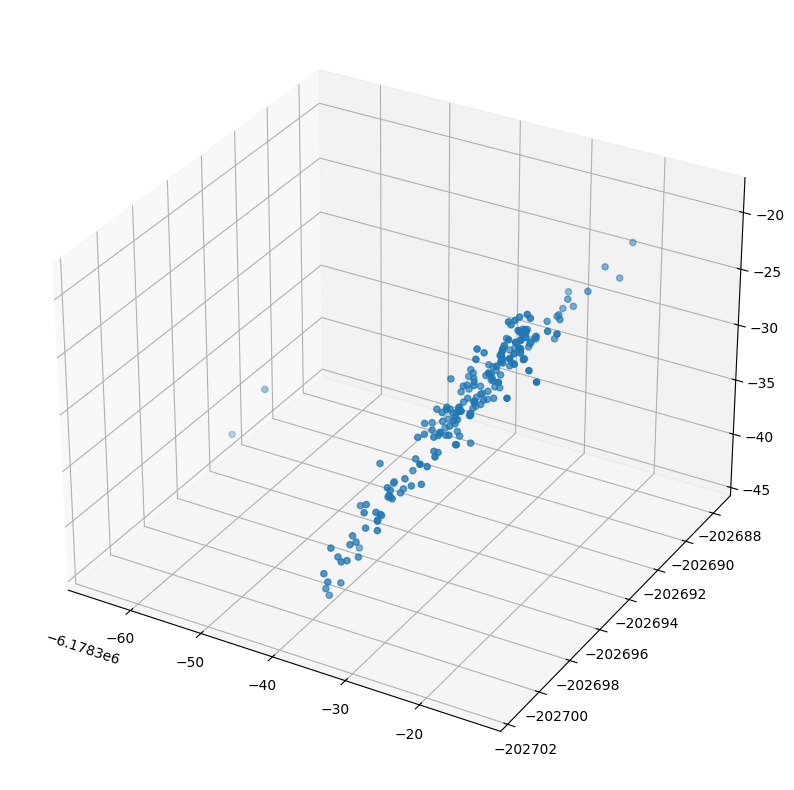

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(sample_data["x"], sample_data["y"], sample_data["z"], label="Estimated trajectory")